# Project: Investigating Maternal Mortality

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I will be analyzing data from Gapminder about maternal mortality across the world. Though there are several common metrics used to measure maternal death, I will be focusing on the maternal mortality ratio, which is defined as the number of women who die from pregnancy-related causes per 100,000 live births. 

In particular, I am interested in exploring the following questions:
* How does maternal mortality vary by region?
* How has maternal mortality changed over time?
* Are there trends that can be observed between maternal mortality and other gender equality indicators?

To investigate the third question, I will also be referencing data from Gapminder about women's education, employment, and representation in government. For each issue, I chose the available indicator with the most data points. The metrics I will be using are, respectively: 
the percentage of girls who complete primary school, the labor force participation rate among women aged 25-54, and the percentage of national parliamentary seats held by women.

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, I will load in the data, check for cleanliness, and then trim and clean the datasets for analysis. I will begin the data wrangling process by exploring the general properties of the datasets that I will be working with. Specifically, I will be looking at its shape and size, the type of data it contains, and whether there is any missing or errant data.

### General Properties

In [3]:
# Load data
mmr_raw = pd.read_csv('mmr_ihme.csv')
edu_raw = pd.read_csv('primary_school_completion_percent_of_girls.csv')
lfpr_raw = pd.read_csv('females_aged_25_54_labour_force_participation_rate_percent.csv') 
gov_raw = pd.read_csv('wn_bothhouses_c.csv')

In [3]:
# Get a sense of MMR data
mmr_raw.head()

,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,496.00,468.00,442.00,434.00,435.00,437.00,441.00,448.0,456.00,...,417.00,396.00,373.00,353.00,335.00,318.00,302.00,289.00,281.00,267.00
1,Albania,28.50,27.00,23.40,20.40,17.30,16.40,15.30,13.8,12.30,...,9.13,8.76,8.47,8.26,7.98,7.75,7.58,7.46,7.33,7.18
2,Algeria,210.00,200.00,194.00,189.00,183.00,177.00,170.00,162.0,152.00,...,91.20,86.70,82.10,78.40,75.00,75.30,73.80,72.70,72.90,71.50
3,Andorra,2.67,2.59,2.57,2.58,2.59,2.52,2.45,2.4,2.34,...,2.10,2.08,2.06,2.00,1.95,1.88,1.92,1.92,1.90,1.88
4,Angola,322.00,315.00,311.00,317.00,320.00,307.00,278.00,267.0,278.00,...,238.00,233.00,227.00,219.00,211.00,205.00,199.00,198.00,193.00,186.00


In [4]:
# Generate descriptive statistics for MMR data
mmr_raw.describe()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,158.746684,156.036010,155.092539,153.207358,152.841244,151.240207,147.650311,146.716788,145.252176,144.647461,...,126.608756,124.014093,121.170881,119.775389,118.528187,116.627668,114.607720,112.630969,111.132021,108.706580
std,166.615699,163.112314,161.821452,160.591407,159.151506,157.467382,156.723180,155.336084,155.190537,154.846467,...,141.121797,139.443272,137.063720,135.217011,133.295958,130.735392,128.946307,127.500965,125.285406,122.064491
min,1.650000,1.640000,1.630000,1.630000,1.640000,1.660000,1.690000,1.730000,1.780000,1.820000,...,1.720000,1.600000,1.530000,1.950000,1.700000,1.330000,1.110000,0.987000,1.520000,1.620000
25%,29.300000,29.500000,28.500000,27.600000,27.400000,30.300000,24.300000,25.900000,24.100000,22.800000,...,17.200000,16.800000,14.500000,14.100000,14.900000,14.000000,13.600000,14.200000,13.300000,13.200000
50%,82.800000,83.600000,84.200000,84.000000,82.100000,79.200000,75.700000,74.000000,72.500000,71.500000,...,64.100000,63.900000,63.200000,65.100000,63.600000,60.400000,59.100000,57.100000,55.800000,55.500000
75%,262.000000,257.000000,262.000000,253.000000,262.000000,257.000000,249.000000,242.000000,239.000000,243.000000,...,202.000000,190.000000,188.000000,180.000000,182.000000,181.000000,180.000000,178.000000,177.000000,177.000000
max,787.000000,778.000000,774.000000,772.000000,756.000000,723.000000,710.000000,688.000000,679.000000,658.000000,...,605.000000,607.000000,607.000000,586.000000,574.000000,561.000000,553.000000,539.000000,532.000000,522.000000


In [5]:
# Print a summary of MMR data
mmr_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 31 columns):
country    193 non-null object
1990       193 non-null float64
1991       193 non-null float64
1992       193 non-null float64
1993       193 non-null float64
1994       193 non-null float64
1995       193 non-null float64
1996       193 non-null float64
1997       193 non-null float64
1998       193 non-null float64
1999       193 non-null float64
2000       193 non-null float64
2001       193 non-null float64
2002       193 non-null float64
2003       193 non-null float64
2004       193 non-null float64
2005       193 non-null float64
2006       193 non-null float64
2007       193 non-null float64
2008       193 non-null float64
2009       193 non-null float64
2010       193 non-null float64
2011       193 non-null float64
2012       193 non-null float64
2013       193 non-null float64
2014       193 non-null float64
2015       193 non-null float64
2016       193 non-null float64


In [6]:
# Print a summary of education data
edu_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 52 columns):
country    185 non-null object
1970       14 non-null float64
1971       48 non-null float64
1972       52 non-null float64
1973       51 non-null float64
1974       55 non-null float64
1975       54 non-null float64
1976       63 non-null float64
1977       65 non-null float64
1978       66 non-null float64
1979       61 non-null float64
1980       61 non-null float64
1981       66 non-null float64
1982       62 non-null float64
1983       65 non-null float64
1984       68 non-null float64
1985       62 non-null float64
1986       63 non-null float64
1987       72 non-null float64
1988       73 non-null float64
1989       64 non-null float64
1990       56 non-null float64
1991       61 non-null float64
1992       71 non-null float64
1993       70 non-null float64
1994       70 non-null float64
1995       67 non-null float64
1996       67 non-null float64
1997       57 non-null floa

In [7]:
# Print a summary of employment data
lfpr_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 42 columns):
country    179 non-null object
1990       179 non-null float64
1991       179 non-null float64
1992       179 non-null float64
1993       179 non-null float64
1994       179 non-null float64
1995       179 non-null float64
1996       179 non-null float64
1997       179 non-null float64
1998       179 non-null float64
1999       179 non-null float64
2000       179 non-null float64
2001       179 non-null float64
2002       179 non-null float64
2003       179 non-null float64
2004       179 non-null float64
2005       179 non-null float64
2006       179 non-null float64
2007       179 non-null float64
2008       179 non-null float64
2009       179 non-null float64
2010       179 non-null float64
2011       179 non-null float64
2012       179 non-null float64
2013       179 non-null float64
2014       179 non-null float64
2015       179 non-null float64
2016       179 non-null float64


In [8]:
# Print a summary of governance data
gov_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 77 columns):
country    193 non-null object
1945       17 non-null float64
1946       37 non-null float64
1947       43 non-null float64
1948       51 non-null float64
1949       54 non-null float64
1950       56 non-null float64
1951       59 non-null float64
1952       62 non-null float64
1953       63 non-null float64
1954       65 non-null float64
1955       67 non-null float64
1956       67 non-null float64
1957       69 non-null float64
1958       70 non-null float64
1959       73 non-null float64
1960       81 non-null float64
1961       85 non-null float64
1962       88 non-null float64
1963       93 non-null float64
1964       98 non-null float64
1965       103 non-null float64
1966       105 non-null float64
1967       107 non-null float64
1968       109 non-null float64
1969       109 non-null float64
1970       112 non-null float64
1971       115 non-null float64
1972       118 non-n

### Data Cleaning

Through the above inspection, I found that the maternal mortality data is differentiated by country, but does not include any regional information. In order to explore how maternal mortality varies by region, I will need to add this data to each row. Since I am adding sub-regional information as well, I will create arrays that contain the sub-regions within each region — this will help facilitate my data analysis further on in the report.

In [4]:
# Add region columns to MMR data
reg = pd.read_csv('continents3.csv')
reg = reg.rename(columns={'name':'country', 'sub-region':'sub_region'})
reg = reg[['country', 'region', 'sub_region']]
reg = reg.replace(to_replace='South-eastern Asia', value="Southeastern Asia")
mmr = pd.merge(mmr_raw, reg, how="left")
mmr = mmr[['country', 'region', 'sub_region']+list(map(str, range(1990, 2020)))]

# Create arrays that contain the sub-regions within each region
africa = mmr.loc[mmr['region'] == "Africa"]['sub_region'].unique()
americas = mmr.loc[mmr['region'] == "Americas"]['sub_region'].unique()
asia = mmr.loc[mmr['region'] == "Asia"]['sub_region'].unique()
europe = mmr.loc[mmr['region'] == "Europe"]['sub_region'].unique()
oceania = mmr.loc[mmr['region'] == "Oceania"]['sub_region'].unique()

Now, I will prepare my data for further analysis. For each question, I will create new dataframe(s) to enable me to examine the maternal mortality rate in that context. Lastly, since I found that two of the dataframes contain null values, I will drop any rows that are missing data from the final version of the dataframes.

In [10]:
# Create new dataframes to analyze MMR by region
mmr_region = mmr
mmr_subregion = mmr

# Group by region and sub-region
mmr_region = mmr_region.groupby("region").mean()
mmr_subregion = mmr_subregion.groupby("sub_region").mean()

# Sort by 2017 values
mmr_region = mmr_region.sort_values('2017')
mmr_subregion = mmr_subregion.sort_values('2017')

In [11]:
# Create new dataframe to analyze MMR over time
mmr_time = mmr

# Transpose data
mmr_time = mmr.groupby("sub_region").mean().transpose() 

# Add years column and reset index
mmr_time.reset_index(inplace=True)
mmr_time.rename(columns={'index':'Year'}, inplace=True)
mmr_time.columns.name = None

# Add row for 2020 with null values
mmr_time.append(pd.Series(), ignore_index=True)
mmr_time.at[30, 'Year'] = 2020

In [12]:
# Define function to clean gender indicator dataframes
def clean_df(df_raw, name, start_year, end_year):
    gen_ind = mmr[['country', 'region', 'sub_region']+list(map(str, range(start_year, end_year+1)))]
    gen_ind = gen_ind.assign(mmr_mean=gen_ind.mean(axis=1))
    gen_ind = gen_ind[['country', 'region', 'sub_region', 'mmr_mean']]
    df = df_raw[['country']+list(map(str, range(start_year, end_year+1)))]
    pd.options.mode.chained_assignment = None # Weird hack to make the next line work
    df[name] = df.mean(axis=1)
    df = df[['country', name]]
    df = pd.merge(gen_ind, df)
    return df

# Create and clean new dataframes to analyze trends between MMR and other gender indicators
edu = clean_df(edu_raw, 'edu_mean', 2010, 2019).dropna()
lfpr = clean_df(lfpr_raw, 'lfpr_mean', 2010, 2019).dropna()
gov = clean_df(gov_raw, 'gov_mean', 2010, 2019).dropna()

<a id='eda'></a>
## Exploratory Data Analysis

### How does maternal mortality vary by region?

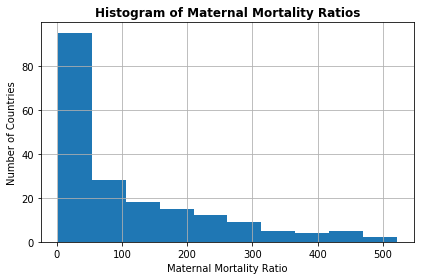

In [21]:
# Frequency distribution of 2017 MMR data
fig, ax = plt.subplots()
ax = mmr['2019'].hist()
ax.set_title('Histogram of Maternal Mortality Ratios', fontweight='bold')
ax.set_xlabel('Maternal Mortality Ratio')
ax.set_ylabel('Number of Countries')
fig.tight_layout()
plt.show()

In [13]:
# 2017 MMR data by region
mmr_region['2017']

region
Europe        6.529452
Asia         72.733333
Americas     86.239714
Oceania     122.867857
Africa      245.070370
Name: 2017, dtype: float64

In [14]:
# 2017 MMR data by sub-region
mmr_subregion['2017']

sub_region
Western Europe                       4.325000
Northern Europe                      4.454700
Southern Europe                      5.640714
Australia and New Zealand            7.275000
Eastern Europe                      11.612000
Northern America                    17.145000
Eastern Asia                        26.146000
Central Asia                        31.640000
Western Asia                        32.565556
Polynesia                           73.000000
Northern Africa                     80.683333
Latin America and the Caribbean     90.427273
Southeastern Asia                   93.826364
Micronesia                         155.600000
Southern Asia                      176.000000
Melanesia                          177.150000
Sub-Saharan Africa                 265.618750
Name: 2017, dtype: float64

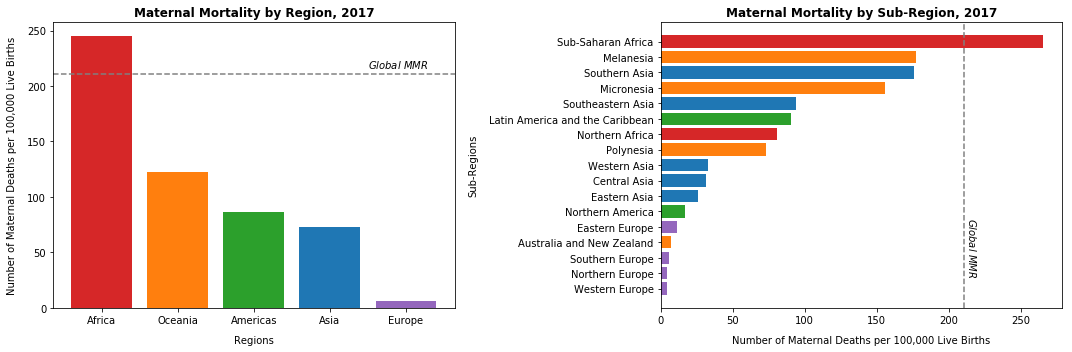

In [15]:
# Create figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Create list to help with iteration
regions = [europe, asia, americas, oceania, africa]

# Create list of colors for subplots
colors1 = ['tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']
colors2 = []
for sr in list(mmr_subregion.index):
    for c, r in zip(colors1, regions):
        if sr in r:
            colors2.append(c)

# Define variables for 2017 MMR regional data
x1_labels = mmr_region.index
x1_pos = np.arange(len(x1_labels))
y1_values = mmr_region['2017']

# Plot and format 2017 MMR regional data
ax1.bar(x1_pos, y1_values, color=colors1)
ax1.set_xticks(x1_pos)
ax1.set_xticklabels(x1_labels)
ax1.invert_xaxis()
ax1.set_title('Maternal Mortality by Region, 2017', fontweight='bold')
ax1.set_xlabel('Regions', labelpad=10)
ax1.set_ylabel('Number of Maternal Deaths per 100,000 Live Births', labelpad=10)
ax1.axhline(y=211, color='grey', ls='--') # Data from UNICEF
ax1.annotate('$Global\ MMR$', xy=(.5, 216))

# Define variables for 2017 MMR sub-regional data
y2_labels = mmr_subregion.index
y2_pos = np.arange(len(y2_labels))
x2_values = mmr_subregion['2017']

# Plot and format 2017 MMR sub-regional data
ax2.barh(y2_pos, x2_values, color=colors2)
ax2.set_yticks(y2_pos)
ax2.set_yticklabels(y2_labels)
ax2.set_title('Maternal Mortality by Sub-Region, 2017', fontweight='bold')
ax2.set_xlabel('Number of Maternal Deaths per 100,000 Live Births', labelpad=10)
ax2.set_ylabel('Sub-Regions', labelpad=10)
ax2.axvline(x=211, color='grey', ls='--') # Data from UNICEF
ax2.annotate('$Global\ MMR$', xy=(212, 4), rotation=270)

fig.tight_layout()
plt.show()

The plots above display the maternal mortality ratio (MMR) by region and sub-region. From the first plot, it is clear that Africa has a much greater MMR relative to the other four regions. Its MMR, 235.36, is roughly double that of the MMR in Oceania, 119.86, the region with the next highest MMR. By contrast, the MMR in Europe is only 6.40, which is by far the lowest of all the five regions.

Taking a closer look at the data via the second plot reveals that there is considerable variation among some of the sub-regions within the same region. Sub-Saharan Africa appears to be driving Africa's high MMR, while Australia and New Zealand are bringing Oceania's MMR down. Southern and Southeastern Asia have a greater MMR than other Asian sub-regions. The MMR in Latin America and the Caribbean is much higher than the MMR in Northern America.


### How has maternal mortality changed over time?

In [16]:
# Change in MMR from 1990 to 2019 by sub-region
mmr_subregion['2019']-mmr_subregion['1990']

sub_region
Western Europe                      -4.595000
Northern Europe                     -8.930000
Southern Europe                     -6.853571
Australia and New Zealand           -2.140000
Eastern Europe                     -21.576000
Northern America                     6.930000
Eastern Asia                       -55.482000
Central Asia                       -24.740000
Western Asia                       -26.429444
Polynesia                          -62.133333
Northern Africa                    -93.800000
Latin America and the Caribbean    -22.193939
Southeastern Asia                 -121.946364
Micronesia                         -29.000000
Southern Asia                     -160.844444
Melanesia                          -28.825000
Sub-Saharan Africa                 -79.620833
dtype: float64

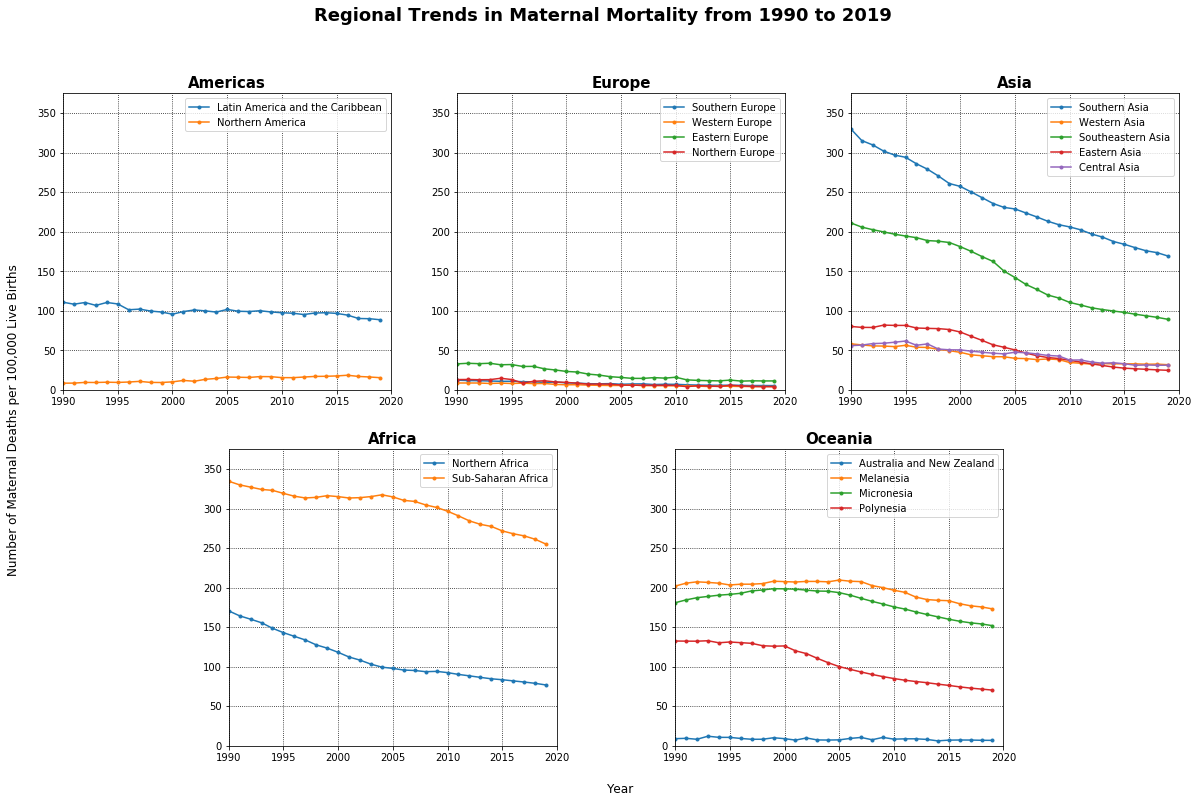

In [17]:
# Create figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# Add title to figure
fig.suptitle('Regional Trends in Maternal Mortality from 1990 to 2019', fontsize=18, fontweight='bold')

# Reposition subplots
axes[1][0].set_position([0.24,0.125,0.228,0.343])
axes[1][1].set_position([0.55,0.125,0.228,0.343])
axes[1][2].set_visible(False)

# Create lists to help with iteration
indexes = [(i, j) for i in range(2) for j in range(3)][:5]
titles = ['Americas', 'Europe', 'Asia', 'Africa', 'Oceania']
regions = [americas, europe, asia, africa, oceania]

# Create subplots for each region
for (i, j), region, title in zip(indexes, regions, titles):
    for sr in region: 
        axes[i][j].plot(mmr_time['Year'], mmr_time[sr], '.-') # plot data
    axes[i][j].set_title(title, fontsize=15, fontweight='bold') # subplot titles
    axes[i][j].legend(loc='upper right') # legends
    axes[i][j].grid(True, color='k', linestyle=':') # gridlines

# Change xticks from every year to every five years
x = mmr_time['Year'][::5].astype('int64')
plt.setp(axes, xticks=x, xticklabels=x, xlim=(1990, 2020), ylim=(0, 375))

# Add axes labels
ax_big = plt.gcf().add_subplot(111, frameon=False)
ax_big.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax_big.set_xlabel('Year', fontsize=12, labelpad=20)
ax_big.set_ylabel('Number of Maternal Deaths per 100,000 Live Births', fontsize=12, labelpad=20)

plt.show()

According to the data displayed in the above figure, over the last three decades, the maternal mortality ratio (MMR) has been trending downward in almost all sub-regions around the world. Southern Asia and Southeastern Asia have seen the greatest drop in MMR: a decrease of 160.84 and 121.95 respectively. Though the MMR in Sub-Saharan Africa has declined by 79.62, its current MMR is still meaningfully greater than in any other sub-region.

In some areas the MMR has remained relatively stable, and only in North America has the MMR increased slightly by 6.93. However, in these cases, the MMR was low to begin with. Unsurprisingly, these sub-regions — Australia and New Zealand, Northern America, and all of Europe — are primarily comprised of wealthy, developed countries. 

### Are there trends that can be observed between maternal mortality and other gender equality indictators?

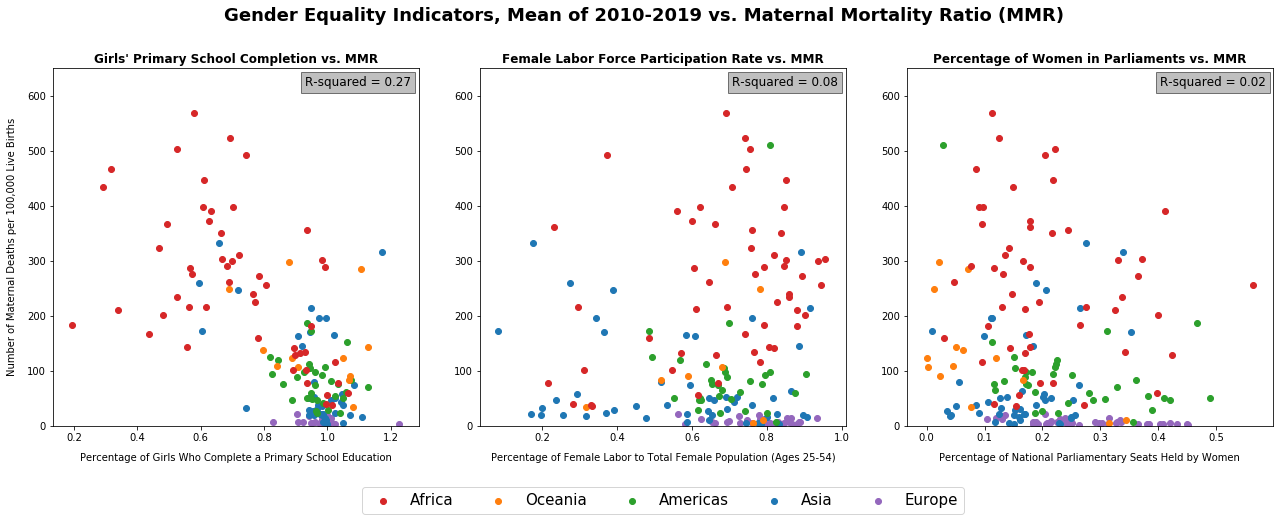

In [18]:
# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Add title to figure
fig.suptitle('Gender Equality Indicators, Mean of 2010-2019 vs. Maternal Mortality Ratio (MMR)', fontsize=18, fontweight='bold', y=1.08)

# Add titles to subplots
ax1.set_title('Girls\' Primary School Completion vs. MMR', fontweight='bold')
ax2.set_title('Female Labor Force Participation Rate vs. MMR', fontweight='bold')
ax3.set_title('Percentage of Women in Parliaments vs. MMR', fontweight='bold')

# Define labels for subplots
mmr_label = 'Number of Maternal Deaths per 100,000 Live Births'
edu_label = 'Percentage of Girls Who Complete a Primary School Education'
lfpr_label = 'Percentage of Female Labor to Total Female Population (Ages 25-54)'
gov_label = 'Percentage of National Parliamentary Seats Held by Women'

# Add labels to subplots
ax1.set_ylabel(mmr_label, labelpad=10)
ax1.set_xlabel(edu_label, labelpad=10)
ax2.set_xlabel(lfpr_label, labelpad=10)
ax3.set_xlabel(gov_label, labelpad=10)

# Create lists to help with iteration
regions = ['Europe', 'Asia', 'Americas', 'Oceania', 'Africa']
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']

# Create subplot for each gender indicator
for reg, col in zip(regions, colors):
    ax1.scatter(edu.loc[edu['region'] == reg]['edu_mean'], edu.loc[edu['region'] == reg]['mmr_mean'], c=col)
    ax2.scatter(lfpr.loc[lfpr['region'] == reg]['lfpr_mean'], lfpr.loc[lfpr['region'] == reg]['mmr_mean'], c=col)
    ax3.scatter(gov.loc[gov['region'] == reg]['gov_mean'], gov.loc[gov['region'] == reg]['mmr_mean'], c=col)

# Define function to calculate r-squared
def rsq(x_values, y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared

# Calculate r-squared for each subplot
edu_rsq = rsq(edu.loc[edu['region'] == reg]['edu_mean'], edu.loc[edu['region'] == reg]['mmr_mean'])
lfpr_rsq = rsq(lfpr.loc[lfpr['region'] == reg]['lfpr_mean'], lfpr.loc[lfpr['region'] == reg]['mmr_mean'])
gov_rsq = rsq(gov.loc[gov['region'] == reg]['gov_mean'], gov.loc[gov['region'] == reg]['mmr_mean'])

# Display r-squared on subplots
ax1.text(.93, 618, "R-squared = "+str(round(edu_rsq, 2)), size='large').set_bbox(dict(facecolor='grey', alpha=0.5))
ax2.text(.7075, 618, "R-squared = "+str(round(lfpr_rsq, 2)), size='large').set_bbox(dict(facecolor='grey', alpha=0.5))
ax3.text(.403, 618, "R-squared = "+str(round(gov_rsq, 2)), size='large').set_bbox(dict(facecolor='grey', alpha=0.5))

# Adjust y-lim for subplots so r-squared values don't cover any data points
ax1.set_ylim([0, 650])
ax2.set_ylim([0, 650])
ax3.set_ylim([0, 650])

# Add legend to figure
handles, l = ax2.get_legend_handles_labels()
labels = regions[::-1]
ax2.legend(handles[::-1], labels, ncol=5, prop={"size":15}, bbox_to_anchor=(.5, -.15), loc='upper center')
fig.subplots_adjust(bottom=0.25)

fig.tight_layout()
plt.show()

Though I expected other gender equality indicators to be predictive of a country's maternal mortality ratio (MMR), there appears to be little correlation between MMR and any of the indicators that I chose to examine. The strongest correlation is between MMR and girls' primary school completion rate, and even that only has an R-squared of 27 percent.

Interestingly, the data points that represent European countries appear to be somewhat concentrated, while the data points that represent African countries seem to be particuarly unrelated.

Upon further reflection, the lack of correlation between these variables makes sense to me. I chose the indicators with the fewest missing values, but they may not have been the best metrics for the questions that I was trying to answer. For example, female labor force participation rate is likely a poor proxy for women's economic empowerment — many women work jobs that are unsafe and low-paying for a paycheck that they will ultimately not have control over.


<a id='conclusions'></a>
## Conclusions

As of 2017, the global maternal mortality ratio (MMR) was 211 — in other words, for every 100,000 births, 211 ended in the mother's death. That hundreds of thousands of women continue to die preventable deaths from pregnancy-related causes every year is a tragedy.

Examining maternal mortality by region reveals a massive level of health inequality across countries. The difference between Norway and Liberia, the countries with the lowest and highest MMRs in 2017, is staggering. With MMRs of 0.987 and 539 respectively, it is clear that some women are at a greater risk of of dying in childbirth than others.

Complications during and following pregnancy and childbirth that were once fatal are now treatable, and, encouragingly, the rate of maternal death has been and continues to decline. This trend hopefully indicates that more women will gain access to the care they need and fewer women will die from a maternal cause.

The findings in this report do not indicate a strong correlation between maternal death and the handful of gender equality indicators explored here. Further investigation must be done before drawing any concrete conclusions. 

This report has important limitations. Comparing the maternal mortality ratios of different countries without access the raw numbers that constitute the ratio (i.e. the number of maternal deaths and the number of live births) is limiting. With more information, it would be possible to make more precise conclusions. Additionally, maternal death is difficult to measure, so the available data is imperfect and sometimes conflicting — for instance, there are discrepencies between the Gapminder dataset used here and data published by the [World Bank](https://data.worldbank.org/indicator/SH.STA.MMRT?end=2017&most_recent_value_desc=true&start=2017&view=bar), [UNICEF](https://data.unicef.org/resources/data_explorer/unicef_f/?ag=UNICEF&df=GLOBAL_DATAFLOW&ver=1.0&dq=.MNCH_MMR..&startPeriod=2016&endPeriod=2021), and even its cited source, the [IHME](http://www.healthdata.org/research-article/global-regional-and-national-levels-and-causes-maternal-mortality-during-1990%E2%80%932013). Finally, this analysis is merely exploratory, and without conducting statistical tests, it is impossible to make statistical conclusions.

In [19]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0